**Imports**

In [1]:
# Packages
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchsummary import summary

# Local files
import data
import encoder
import decoder
import training

# Random Seed
torch.manual_seed(0)

c:\Users\kobil\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Load Data**

In [2]:
train_ds, val_ds, test_ds = data.get_datasets()

Files already downloaded and verified
Files already downloaded and verified


In [3]:
batch_size = 64

train_dl = data.dataset_to_dataloader(train_ds, batch_size)
val_dl = data.dataset_to_dataloader(val_ds, batch_size)
test_dl = data.dataset_to_dataloader(test_ds, batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


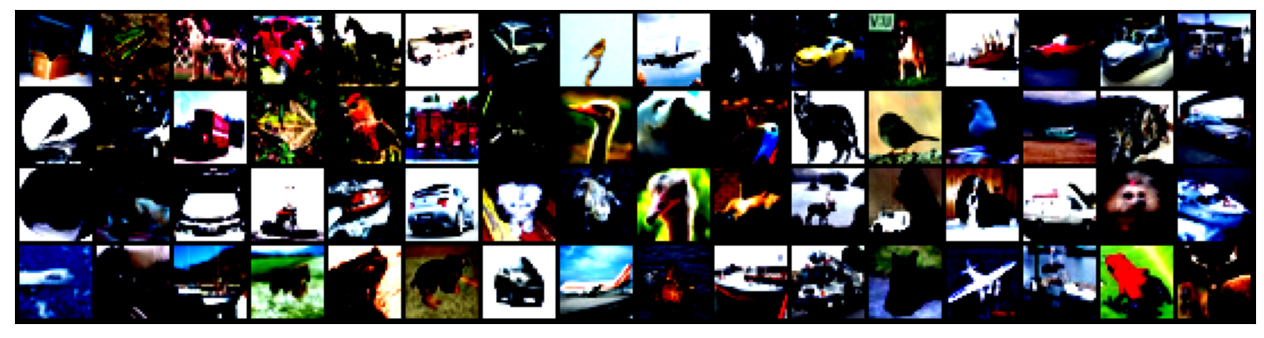

In [4]:
data.test_dataloader(train_dl)

**Create Encoders**

In [5]:
resnet_pt = encoder.resnet18(pretrained=True)
resnet_ut = encoder.resnet18(pretrained=False)

In [6]:
for param in resnet_pt.parameters():
    param.requires_grad = False

resnet_pt.avgpool = nn.AdaptiveAvgPool2d((1, 1))
resnet_pt.fc = nn.Linear(in_features=512, out_features=10, bias=True)


In [7]:
"""
if torch.cuda.is_available():
  resnet_pt.to(torch.device('cuda:0'))
  resnet_ut.to(torch.device('cuda:0'))
"""

"\nif torch.cuda.is_available():\n  resnet_pt.to(torch.device('cuda:0'))\n  resnet_ut.to(torch.device('cuda:0'))\n"

In [8]:
"""
print("Classification task accuracy")
pt_acc = str(encoder._classification_eval(resnet_pt, val_dl))
ut_acc = str(encoder._classification_eval(resnet_ut, val_dl))
print("Pretrained model accuracy:", pt_acc)
print("Untrained model accuracy:", ut_acc)
"""

'\nprint("Classification task accuracy")\npt_acc = str(encoder._classification_eval(resnet_pt, val_dl))\nut_acc = str(encoder._classification_eval(resnet_ut, val_dl))\nprint("Pretrained model accuracy:", pt_acc)\nprint("Untrained model accuracy:", ut_acc)\n'

In [9]:
control_decoder = decoder.ResNet18Dec()
experiment_decoder = decoder.ResNet18Dec()

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self,encoder_model, decoder_model, z_dim = 10):
        super().__init__()
        self.encoder = encoder_model
        self.decoder = decoder_model

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [11]:
Control_AE = AutoEncoder(resnet_ut, control_decoder)
Expirement_AE = AutoEncoder(resnet_pt, control_decoder)

In [12]:
if torch.cuda.is_available():
  Control_AE.to(torch.device('cuda:0'))
  Expirement_AE.to(torch.device('cuda:0'))


In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Control_AE.parameters())

Control_AE, Control_hist = training.train(Control_AE,
            criterion,
            optimizer,
            train_dl,
            val_dl,
            save_file_name='Control_AE.pt',
            max_epochs_stop = 5,
            n_epochs = 20,
            print_every = 1)


Starting Training from Scratch.

Epoch: 0	100.00% complete. 115.12 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 0.5709 	Validation Loss: 0.3872
Epoch: 1	100.00% complete. 114.09 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.3656 	Validation Loss: 0.3467
Epoch: 2	100.00% complete. 112.79 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.3532 	Validation Loss: 0.3417
Epoch: 3	100.00% complete. 112.81 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.3476 	Validation Loss: 0.3554
Epoch: 4	100.00% complete. 112.18 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.3429 	Validation Loss: 0.3421
Epoch: 5	100.00% complete. 112.84 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.3386 	Validation Loss: 0.3430
Epoch: 6	100.00% complete. 112.59 seconds elapsed in epoch.
Epoch: 6 	Training Loss: 0.3336 	Validation Loss: 0.3709
Epoch: 7	100.00% complete. 112.34 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.3328 	Validation Loss: 0.3423

Early Stopping! Total epochs: 

In [14]:
Control_AE

AutoEncoder(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


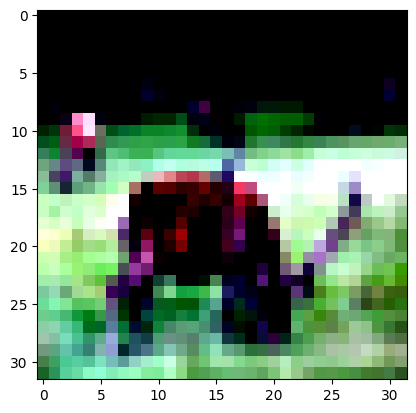

In [48]:
test_img = test_dl.dataset[0][0]
plt.imshow(test_img.permute(1,2,0))

In [50]:

test_img = torch.reshape(test_img,(1,3,32,32)).cuda()
output_img = Control_AE(test_img)
output_img = torch.reshape(output_img,(3,32,32))
output_img = output_img.cpu().detach()
output_img = output_img.numpy()
output_img = np.transpose(output_img, (1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


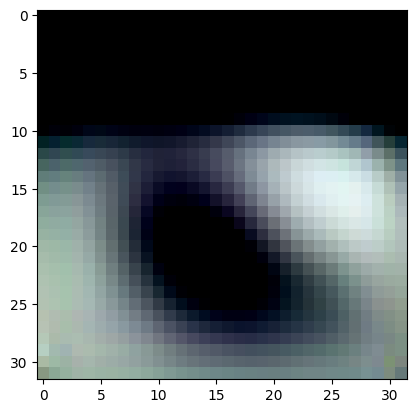

In [51]:
plt.imshow(output_img)